In [3]:
tokenizer_checkpoint = "bert-base-uncased"
dataset_name = "imdb"

In [4]:
from transformers import AutoModelForSequenceClassification
from chop import MaseGraph
import chop.passes as passes

In [5]:
from pathlib import  Path
from chop import MaseGraph

mg = MaseGraph.from_checkpoint(f"{Path.cwd()}/../tutorial3/best_model")

In [6]:
from chop.tools import get_tokenized_dataset, get_trainer

dataset, tokenizer = get_tokenized_dataset(
    dataset=dataset_name,
    checkpoint=tokenizer_checkpoint,
    return_tokenizer=True
)

trainer = get_trainer(
    model=mg.model,
    tokenized_dataset=dataset,
    tokenizer=tokenizer,
    evaluate_metric="accuracy",
)


eval_results=trainer.evaluate()
print(f"Base Model Acc: {eval_results['eval_accuracy']}")
print(eval_results)

INFO     Tokenizing dataset imdb with AutoTokenizer for bert-base-uncased.
Map: 100%|██████████| 50000/50000 [00:13<00:00, 3805.27 examples/s]


Base Model Acc: 0.8332
{'eval_loss': 0.38564127683639526, 'eval_model_preparation_time': 0.0004, 'eval_accuracy': 0.8332, 'eval_runtime': 27.5516, 'eval_samples_per_second': 907.388, 'eval_steps_per_second': 113.424}


In [7]:
pc = {
    "weight": {
        "sparsity": 0.5,
        "method": "l1-norm",
        "scope": "local"
    },
    "activation": {
        "sparsity": 0.5,
        "method": "l1-norm",
        "scope": "local"
    }
}

In [2]:
import pandas as pd

def search_prune(strat: str) -> None:
    mg = MaseGraph.from_checkpoint(f"{Path.home()}/mase/tasks/tutorial3/best_model")
    prune_pretrain = [0 for i in range(1, 10)]
    prune_ac = [0 for i in range(1, 10)]
    pc_template = pc



    for i in range(1, 10):
        print(f'iter: {i}')
        pc_template["weight"]["sparsity"] = float(i) / 10.0
        pc_template["activation"]["sparsity"] = float(i) / 10.0
        pc_template["activation"]["method"] = strat
        pc_template["weight"]["method"] = strat
        mg, _ = passes.prune_transform_pass(mg, pc_template)

        trainer = get_trainer(
            model=mg.model,
            tokenized_dataset=dataset,
            tokenizer=tokenizer,
            evaluate_metric="accuracy",
        )

        eval_results = trainer.evaluate()

        prune_pretrain[i-1] = eval_results['eval_accuracy']

        trainer.train()

        eval_results2 = trainer.evaluate()

        prune_ac[i-1] = eval_results2['eval_accuracy']

    data = []

    for i in range(1, 10):
        data.append({
            "sparsity" : float(i)/10.0,
            "pretrain": prune_pretrain[i-1],
            "posttrain": prune_ac[i-1]
        })

    df = pd.DataFrame(data)
    df.to_csv(f"{Path.home()}/mase/tasks/tutorial4/prune_dt_{strat.replace('-', '_')}_1.csv", index=False)


In [ ]:
search_prune("l1-norm")
search_prune("random")

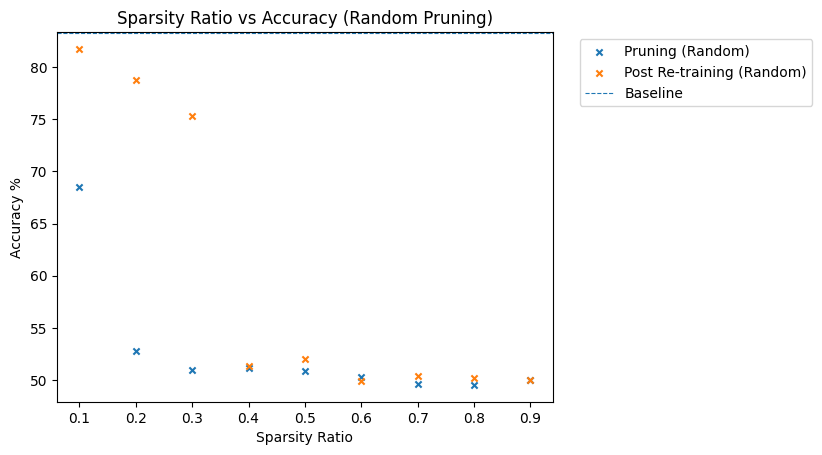

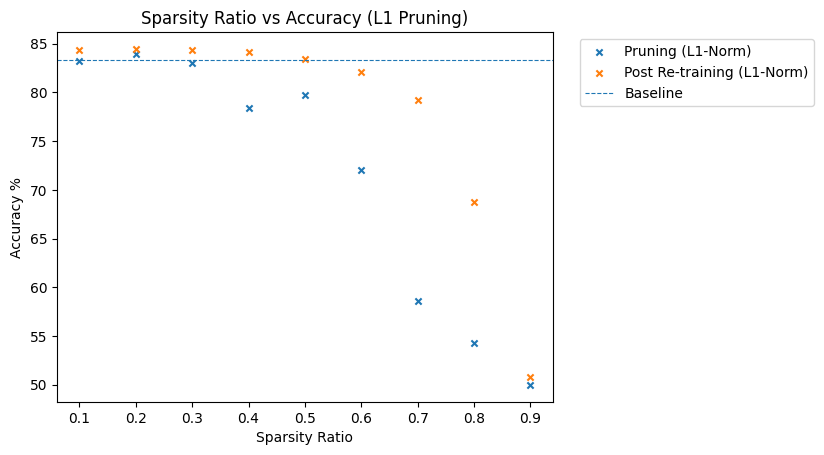

In [29]:
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

df_r = pd.read_csv(f"{Path.cwd()}/prune_dt_random.csv")
df_l = pd.read_csv(f"{Path.cwd()}/prune_dt_l1_norm.csv")

fig = plt.figure()
plt.scatter(x=df_r['sparsity'], y=df_r['pretrain'] * 100, marker='x', s=20)
plt.scatter(x=df_r['sparsity'], y=df_r['posttrain'] * 100, marker='x', s=20)
plt.axhline(y=eval_results['eval_accuracy'] * 100, linestyle='--', linewidth=0.8)
lgd = plt.legend(['Pruning (Random)', 'Post Re-training (Random)', 'Baseline'], bbox_to_anchor=(1.04, 1), loc="upper left")
plt.xlabel("Sparsity Ratio")
plt.ylabel("Accuracy %")
plt.title("Sparsity Ratio vs Accuracy (Random Pruning)")
plt.savefig(f"{Path.cwd()}/sparse_random", bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

fig = plt.figure()
plt.title("Sparsity Ratio vs Accuracy (L1 Pruning)")
plt.scatter(x=df_l['sparsity'], y=df_l['pretrain'] * 100, marker='x', s=20)
plt.scatter(x=df_l['sparsity'], y=df_l['posttrain'] * 100, marker='x', s=20)
plt.axhline(y=eval_results['eval_accuracy'] * 100, linestyle='--', linewidth=0.8)
lgd = plt.legend(['Pruning (L1-Norm)', 'Post Re-training (L1-Norm)', 'Baseline'], bbox_to_anchor=(1.04, 1), loc="upper left")
plt.xlabel("Sparsity Ratio")
plt.ylabel("Accuracy %")
plt.savefig(f"{Path.cwd()}/sparse_l1", bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()



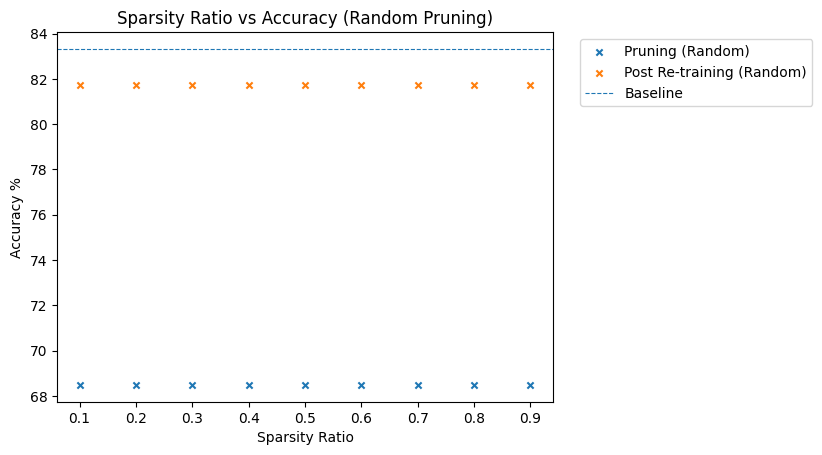

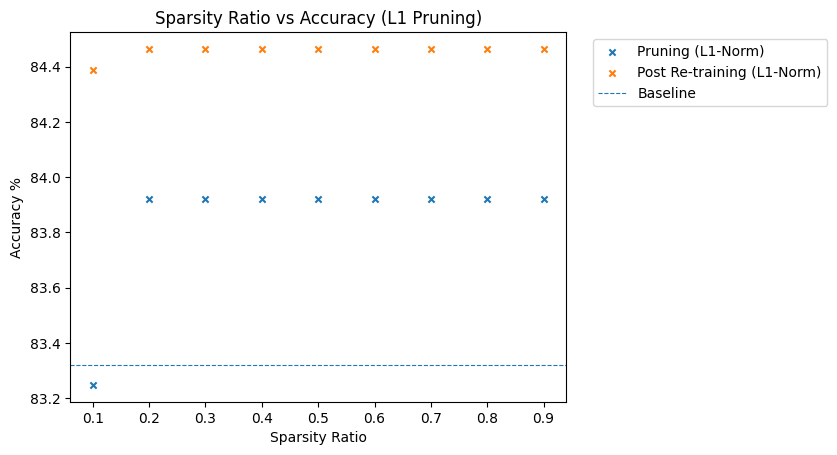

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

df_r = pd.read_csv(f"{Path.cwd()}/prune_dt_random.csv")
df_l = pd.read_csv(f"{Path.cwd()}/prune_dt_l1_norm.csv")

fig = plt.figure()
plt.scatter(x=df_r['sparsity'], y=df_r['pretrain'].cummax()* 100, marker='x', s=20)
plt.scatter(x=df_r['sparsity'], y=df_r['posttrain'].cummax() * 100, marker='x', s=20)
plt.axhline(y=eval_results['eval_accuracy'] * 100, linestyle='--', linewidth=0.8)
lgd = plt.legend(['Pruning (Random)', 'Post Re-training (Random)', 'Baseline'], bbox_to_anchor=(1.04, 1), loc="upper left")
plt.xlabel("Sparsity Ratio")
plt.ylabel("Accuracy %")
plt.title("Sparsity Ratio vs Accuracy (Random Pruning)")
plt.savefig(f"{Path.cwd()}/sparse_random_max", bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

fig = plt.figure()
plt.title("Sparsity Ratio vs Accuracy (L1 Pruning)")
plt.scatter(x=df_l['sparsity'], y=df_l['pretrain'].cummax() * 100, marker='x', s=20)
plt.scatter(x=df_l['sparsity'], y=df_l['posttrain'].cummax() * 100, marker='x', s=20)
plt.axhline(y=eval_results['eval_accuracy'] * 100, linestyle='--', linewidth=0.8)
lgd = plt.legend(['Pruning (L1-Norm)', 'Post Re-training (L1-Norm)', 'Baseline'], bbox_to_anchor=(1.04, 1), loc="upper left")
plt.xlabel("Sparsity Ratio")
plt.ylabel("Accuracy %")
plt.savefig(f"{Path.cwd()}/sparse_l1_max", bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()



In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

# Load data
df_r = pd.read_csv(f"{Path.cwd()}/prune_dt_random.csv")
df_l = pd.read_csv(f"{Path.cwd()}/prune_dt_l1_norm.csv")

# Extract highest achieved accuracy for both methods
highest_accuracy_random = df_r[['pretrain', 'posttrain']].max() * 100
highest_accuracy_l1 = df_l[['pretrain', 'posttrain']].max() * 100
print(highest_accuracy_l1)
# Create the figure
fig = plt.figure()

# Plot data
# plt.scatter(df_r['sparsity'], highest_accuracy_random['pretrain'], marker='x', s=40, label='Pretrain (Random)')
# plt.scatter(df_r['sparsity'], highest_accuracy_l1['posttrain'], marker='x', s=40, label='Posttrain (Random)')
# plt.scatter(df_l['sparsity'], df_l['pretrain'] * 100, marker='o', s=40, label='Pretrain (L1)')
# plt.scatter(df_l['sparsity'], df_l['posttrain'] * 100, marker='o', s=40, label='Posttrain (L1)')
#
# # Highlight the highest achieved accuracy for each method
# # ax.axhline(highest_accuracy_random, color='blue', linestyle='--', linewidth=0.8, label=f'Highest Accuracy (Random): {highest_accuracy_random:.2f}%')
# # ax.axhline(highest_accuracy_l1, color='orange', linestyle='--', linewidth=0.8, label=f'Highest Accuracy (L1): {highest_accuracy_l1:.2f}%')
#
# # Add legend, labels, and title
# plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
# plt.xlabel("Sparsity Ratio")
# plt.ylabel("Accuracy %")
# plt.title("Sparsity Ratio vs Highest Accuracy on IMDb")
#
# # Adjust layout and save the figure
# plt.tight_layout()
# plt.savefig(f"{Path.cwd()}/sparse_comparison", bbox_inches='tight')
# plt.show()


pretrain     83.920
posttrain    84.464
dtype: float64


<Figure size 640x480 with 0 Axes>

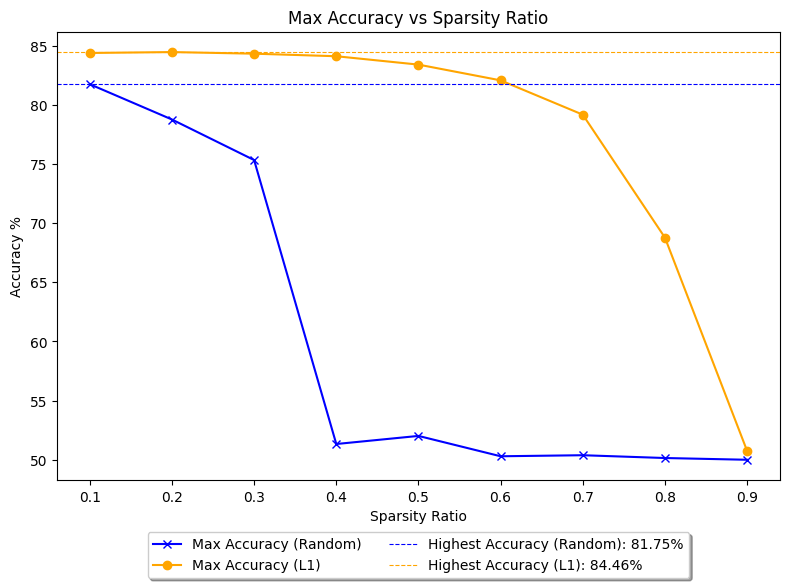

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

# Load data
df_r = pd.read_csv(f"{Path.cwd()}/prune_dt_random.csv")
df_l = pd.read_csv(f"{Path.cwd()}/prune_dt_l1_norm.csv")

# Compute max accuracy for each sparsity level
df_r['max_accuracy'] = df_r[['pretrain', 'posttrain']].max(axis=1) * 100
df_l['max_accuracy'] = df_l[['pretrain', 'posttrain']].max(axis=1) * 100

# Extract highest achieved accuracy for both methods
highest_accuracy_random = df_r['max_accuracy'].max()
highest_accuracy_l1 = df_l['max_accuracy'].max()

# Create the figure
fig, ax = plt.subplots(figsize=(8, 6))  # Increase figure size for better spacing

# Plot max accuracy vs sparsity for both methods
ax.plot(df_r['sparsity'], df_r['max_accuracy'], marker='x', linestyle='-', label='Max Accuracy (Random)', color='blue')
ax.plot(df_l['sparsity'], df_l['max_accuracy'], marker='o', linestyle='-', label='Max Accuracy (L1)', color='orange')

# Highlight the highest achieved accuracy for each method
ax.axhline(highest_accuracy_random, color='blue', linestyle='--', linewidth=0.8, label=f'Highest Accuracy (Random): {highest_accuracy_random:.2f}%')
ax.axhline(highest_accuracy_l1, color='orange', linestyle='--', linewidth=0.8, label=f'Highest Accuracy (L1): {highest_accuracy_l1:.2f}%')

# Add legend, labels, and title
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=2)  # Legend below the plot
ax.set_xlabel("Sparsity Ratio")
ax.set_ylabel("Accuracy %")
ax.set_title("Max Accuracy vs Sparsity Ratio")

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig(f"{Path.cwd()}/sparse_max_comparison.png", bbox_inches='tight')
plt.show()
